In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [3]:
df = pd.read_csv('Spotify_Combined.csv')
df.drop(['index','id','uri'], axis=1, inplace=True)

In [4]:
#number of cases and attributes in the dataset
n = len(df)
ncol = len(df.columns)-1
print "There are {0:} cases in the dataset".format(n)
print "There are {0:} attributes in the dataset".format(ncol)

There are 1420 cases in the dataset
There are 15 attributes in the dataset


Text(0.5,1,u"Class 'Mood' Distribution")

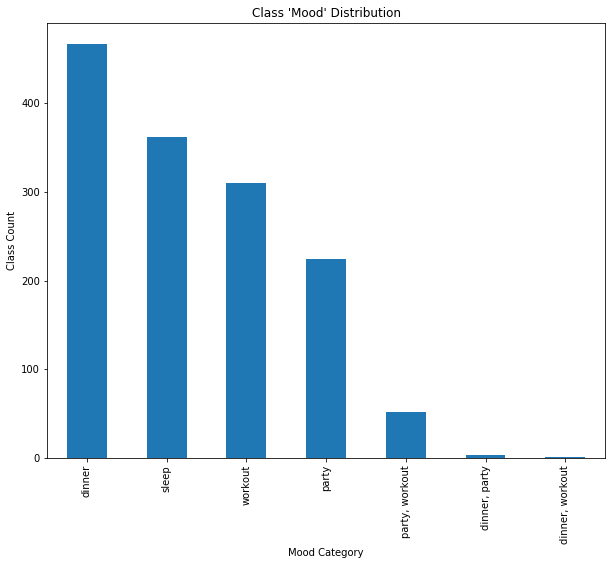

In [5]:
#plotting the distribution. heavily imbalanced
figure(figsize=(10,8))
df['mood(s)'].value_counts().plot(kind='bar')
plt.xlabel("Mood Category")
plt.ylabel("Class Count")
plt.title("Class 'Mood' Distribution")

In [6]:
#percentage of 'name' column where a song title only appears once
name_pct = float(df["name"].value_counts().value_counts()[1])/len(df["name"])
print "{0:.2f}% of values in the 'name' attribute only appear once".format(name_pct * 100)

94.15% of values in the 'name' attribute only appear once


In [7]:
#percentage of 'Artist(s)' column where a song title only appears once
artist_pct = float(df["artist"].value_counts().value_counts()[1])/len(df["artist"])
print "{0:.2f}% of values in the 'artist' attribute only appear once".format(artist_pct * 100)

69.72% of values in the 'artist' attribute only appear once


In [8]:
#dropping "name" and "artist" features since they are long tail and won't be as useful being categorial
df.drop(['name','artist'], axis=1, inplace=True)

#### Finding new "single" mood labels for the labels that can fall in both categories through KNN. Excluding the combination labels from the training/testing, using stratified sampling, and then determining new labels on the combination instances as a validation set.

In [9]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.model_selection import StratifiedKFold

In [10]:
def perfReport(ytest, ypredict, output='metrics'): 
    cm = pd.DataFrame(data=confusion_matrix(ytest, ypredict, 
                      labels=['dinner', 'sleep', 'workout', 'party']),
                      columns=['dinner_pred', 'sleep_pred', 'workout_pred', 'party_pred'],
                      index=['dinner_true', 'sleep_true', 'workout_true', 'party_true'])
    
    cols = ['Sensitivity', 'Specificity', 'F1', 'Accuracy']
    dfperf = pd.DataFrame(index=['dinner', 'sleep', 'workout', 'party'], 
                          columns=cols)
    
    diagsum = 0
    for i in range(0,len(cm)):
        diagsum += cm.iloc[i,i]
        
    for j in range(0, len(cm)):
        tp = cm.iloc[j,j]
        fp = int(cm.iloc[:,j].sum())-tp
        fn = int(cm.iloc[j,:].sum())-tp
        tn = diagsum - tp
        
        sens = float(tp) / (tp+fn)
        spec = float(tn) / (tn+fp)
        f1 = (2*float(tp)) / (2*tp+fp+fn)
        acc = float(tp+tn) / (tp+tn+fp+fn)
        
        dfperf.iloc[j,0] = sens
        dfperf.iloc[j,1] = spec
        dfperf.iloc[j,2] = f1
        dfperf.iloc[j,3] = acc
    
    if output == 'metrics':
        return dfperf
    elif output == 'cm':
        return cm

In [11]:
def KNNpipe(xtrn, xtst, ytrn, ytst, nneigh=3, scaled=1, output='stats'):
    if scaled == 1:
        mypipeline = Pipeline([
            ('myscaler', StandardScaler()),
            ('masterAlg', KNeighborsClassifier(n_neighbors=nneigh))
        ])
    else:
        mypipeline = Pipeline([
            ('masterAlg', KNeighborsClassifier(n_neighbors=nneigh))
        ])
    
    mypipeline.fit(xtrn, ytrn)
    yprd = mypipeline.predict(xtst)
    yprd_prob = mypipeline.predict_proba(xtst)
    
    if output == 'stats':
        return perfReport(ytst, yprd)
    elif output == 'raw':
        return yprd
    elif output == 'cm':
        return perfReport(ytst, yprd, output='cm')

In [12]:
#returns a table of performance for classes based on a grid search of neighbors
def KNNgrid(xtrn, xtst, ytrn, ytst, numneigh=50, scaled=1, output='stats'):
    neigh_range = [i for i in range(1, numneigh,2)]
    frames = [KNNpipe(xtrn, xtst, ytrn, ytst, 
                      nneigh=j, scaled=scaled, output=output) for j in neigh_range]
    results = pd.concat(frames, keys=neigh_range)
    
    return results

In [13]:
#function for plotting the performance of the classifier at different neighbor values
def plotNeighbors(dfgrid, metric='F1', maxtick=50):
    figure(figsize=(12,7))
    x = list(set(dfgrid.index.get_level_values(0)))
    moods = ['dinner', 'sleep', 'workout', 'party']
    for mood in moods:
        vals = [dfgrid.loc[(j, mood), metric] for j in x] 
        plt.plot(x, vals)
    plt.title(metric + ' Score for Each Mood vs KNN # of Neighbors')
    plt.xlabel('Number of Neighbors') 
    plt.ylabel(metric+' Score')
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5),labels=moods)
    plt.grid(True)
    plt.xticks(np.arange(1,maxtick,2))

In [14]:
#making a list of the combination values to exclude, and a copy of the dataframe without them
exclude_vals = ['party, workout', 'dinner, party', 'dinner, workout']

df_multi = df.loc[df['mood(s)'].isin(exclude_vals)]
df_f = df.loc[~df['mood(s)'].isin(exclude_vals) ]

In [15]:
#setting up attributes and targets, and splitting into stratified training, testing, and validation...
#... with the multi-label classes excluded at the moment
# 66/33 training and testing in the first split of df_f
# 80/20 of the training from the previous split for training and testing in fixing multi-labels
# => 53% training and 13% testing as a subset of the full 66% training (fixing multi-labels)
# Training and testing will be used for learning best labels to put on mulit-label mood instances...
#... and then the multi-labels will be added to testing and the full 66% used for training with the...
#...33% testing to determine the best model

seed = 3
X, y = df_f.iloc[:, 0:len(df_f.columns)-1], df_f['mood(s)']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.33, 
                                                    random_state=seed)

X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X_train, y_train,
                                                               stratify=y_train,
                                                               test_size=0.20,
                                                               random_state=seed)

# setting the multi-labels as validation sets for the subtraining to fix labels
X_subval, y_subval = df_multi.iloc[:, 0:len(df_multi.columns)-1], df_multi['mood(s)']

In [16]:
sub_grid = KNNgrid(X_subtrain, X_subtest, y_subtrain, y_subtest,numneigh=50, scaled=1)

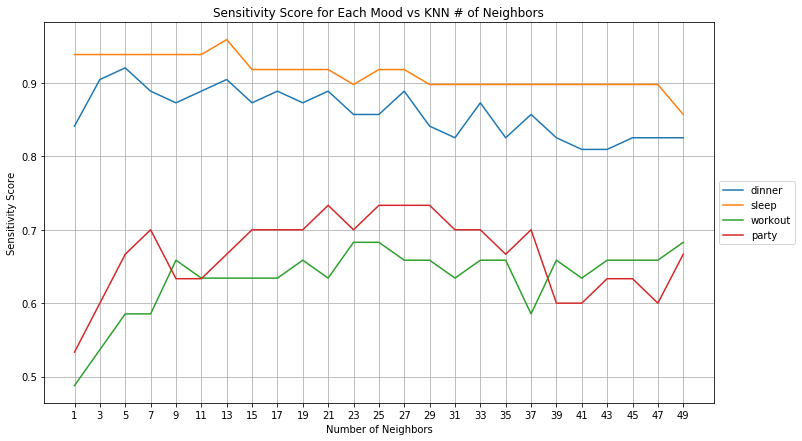

In [16]:
plotNeighbors(sub_grid,metric='Sensitivity')

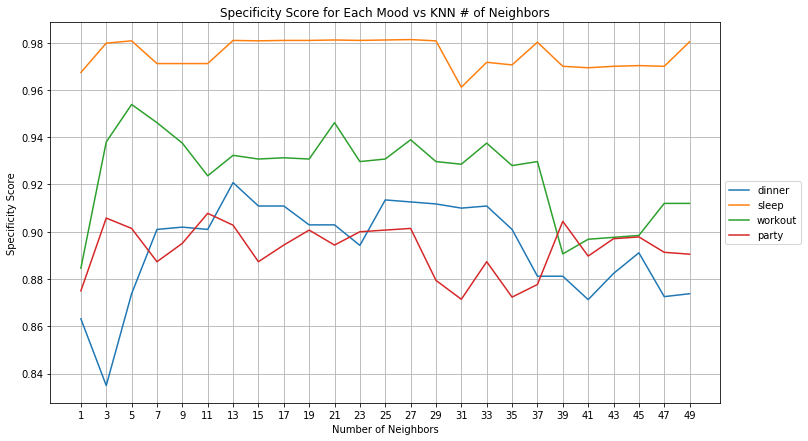

In [17]:
plotNeighbors(sub_grid,metric='Specificity')

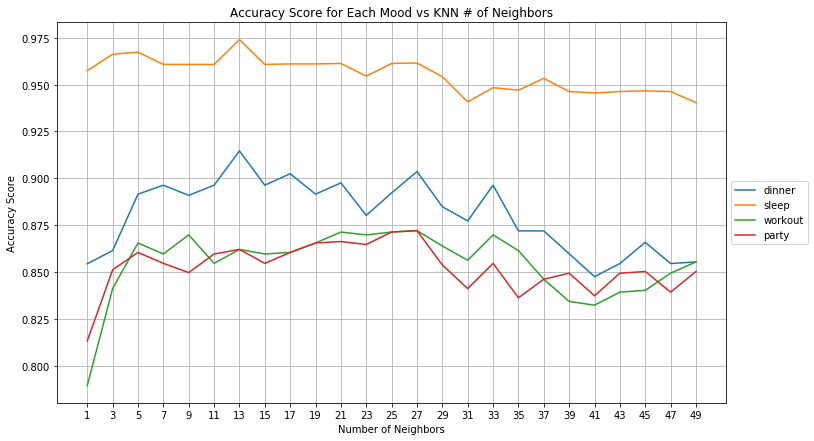

In [18]:
plotNeighbors(sub_grid,metric='Accuracy')

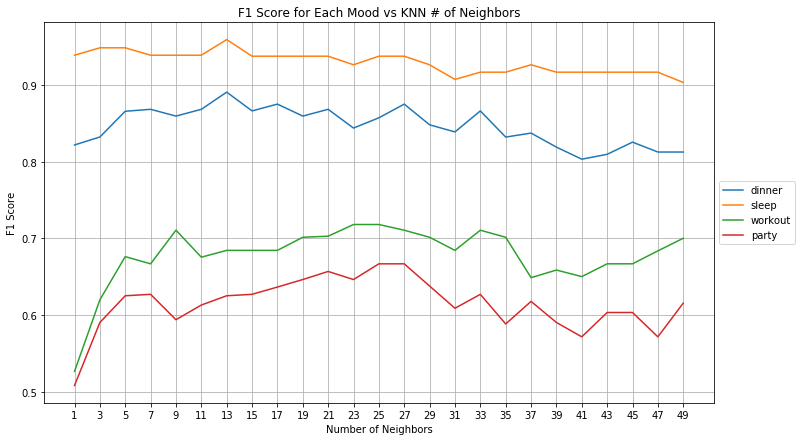

In [19]:
plotNeighbors(sub_grid,metric='F1')

#### The model appears to do best with classification of the different classes when using 13 neighbors, which has a minimum F1 score of 62.5% for party and maximum F1 score for sleep above 95.9%. Sleep and dinner appear to be the most confidently classified, and there is some ambiguity between the workout and party playlists

#### Now we apply the model with 13 neighbors to the multi-value classes to determine new labels

In [21]:
y_subvalpred = KNNpipe(X_subtrain, X_subval, y_subtrain, y_subval,
                    nneigh=13, scaled=1, output='raw')

In [22]:
# removing old combination label and using the model to attribute new labels
df_multi.drop('mood(s)', axis=1, inplace=True) 
df_multi = pd.concat([df_multi, 
                      pd.DataFrame(data=y_subvalpred, index=df_multi.index, columns=['mood(s)'])],
                     axis=1, ignore_index=False)

C:\Users\Charlie\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
# combining the edited multi-class dataset with the full training set
X_train = pd.concat([df_multi.iloc[:,0:len(df_multi.columns)-1], X_train.copy()])
y_train = pd.concat([df_multi.iloc[:,len(df_multi.columns)-1], y_train.copy()])

### Plotting the data using two randomly selected variables

In [24]:
#making a copy of the full dataframe with fixed multi-class labels
X_temp = pd.concat([X_train, X_test])
y_temp = pd.concat([y_train, y_test])
df2 = pd.concat([X_temp, y_temp], axis=1)

Text(0,0.5,u'mode')

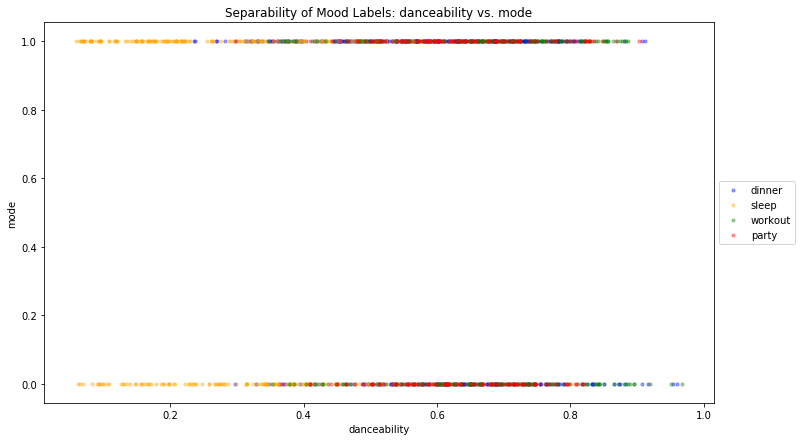

In [25]:
#getting random choices to plot for each class
choices = np.random.choice(X_train.columns, 2, replace=False)
x1_rand, x2_rand = choices[0], choices[1]

#setting up different points to plot for each class
mood1 = df2.loc[df2['mood(s)']=='dinner']
mood2 = df2.loc[df2['mood(s)']=='sleep']
mood3 = df2.loc[df2['mood(s)']=='workout']
mood4 = df2.loc[df2['mood(s)']=='party']

groups = (mood1, mood2, mood3, mood4)
labels = ['dinner', 'sleep', 'workout', 'party']
colors = ['blue', 'orange', 'green', 'red']

figure(figsize=(12,7))
for g, l, c in zip(groups, labels, colors):
    plt.scatter(g[x1_rand], g[x2_rand], c=c, alpha=0.35, label=l, s=10)
    
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("Separability of Mood Labels: " + x1_rand + " vs. " + x2_rand)
plt.xlabel(x1_rand)
plt.ylabel(x2_rand)

### Decision Tree Analysis

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
#setting up a results table to handle the different combos
tree_table = pd.DataFrame(columns=['Model No',
                                   'Label',
                                   'Criterion',
                                   'Class Weight',
                                   'Min Samples Split',
                                   'Min Samples Leaf',
                                   'Sensitivity',
                                   'Specificity',
                                   'F1 Score',
                                   'Accuracy'])

In [28]:
#doing a grid search of some parameters 
modelno = int(1)
for crit in ['gini', 'entropy']:
    for weight in [None, 'balanced']:
        for min_split in range(10, 50, 10):
            for min_leaf in range(5, 35, 10):
                tree = DecisionTreeClassifier(random_state=0, 
                                               criterion=crit,
                                               class_weight=weight,
                                               min_samples_split=min_split,
                                               min_samples_leaf=min_leaf)
                tree.fit(X_train, y_train)
                y_pred_tmp = tree.predict(X_test)
                res_tmp = perfReport(y_test, y_pred_tmp, output='metrics')
                
                for lab in ['dinner', 'sleep', 'workout', 'party']:
                    tsens = res_tmp.loc[lab][0]
                    tspec = res_tmp.loc[lab][1]
                    tf1 = res_tmp.loc[lab][2]
                    tacc = res_tmp.loc[lab][3]
                    frame_tmp = pd.DataFrame(data=np.array([[int(modelno),
                                                             lab,
                                                             crit,
                                                             weight,
                                                             min_split,
                                                             min_leaf,
                                                             tsens,
                                                             tspec,
                                                             tf1,
                                                             tacc]]),
                                            columns=['Model No',
                                                     'Label',
                                                     'Criterion',
                                                     'Class Weight',
                                                     'Min Samples Split',
                                                     'Min Samples Leaf',
                                                     'Sensitivity',
                                                     'Specificity',
                                                     'F1 Score',
                                                     'Accuracy'])
                    tree_table = tree_table.append(frame_tmp)
                
                modelno += 1
                    

In [29]:
tree_table.sort_values(by='Model No', ascending=True).head(20)

,Model No,Label,Criterion,Class Weight,Min Samples Split,Min Samples Leaf,Sensitivity,Specificity,F1 Score,Accuracy
0,1,dinner,gini,None,10,5,0.818182,0.814961,0.770642,0.816176
0,1,sleep,gini,None,10,5,0.875,0.946058,0.882353,0.922438
0,1,workout,gini,None,10,5,0.621359,0.921233,0.673684,0.843038
0,1,party,gini,None,10,5,0.513514,0.893939,0.517007,0.824257
0,2,dinner,gini,None,10,15,0.876623,0.795367,0.789474,0.825666
0,2,sleep,gini,None,10,15,0.841667,0.97561,0.889868,0.931694
0,2,workout,gini,None,10,15,0.631068,0.938776,0.698925,0.858942
0,2,party,gini,None,10,15,0.540541,0.901198,0.544218,0.835784
0,3,party,gini,None,10,25,0.405405,0.933121,0.48,0.832474
0,3,workout,gini,None,10,25,0.68932,0.871972,0.672986,0.82398


In [30]:
tree_table[tree_table['Model No']=='41']

,Model No,Label,Criterion,Class Weight,Min Samples Split,Min Samples Leaf,Sensitivity,Specificity,F1 Score,Accuracy
0,41,dinner,entropy,balanced,20,15,0.74025974026,0.872586872587,0.757475083056,0.823244552058
0,41,sleep,entropy,balanced,20,15,0.916666666667,0.95041322314,0.909090909091,0.939226519337
0,41,workout,entropy,balanced,20,15,0.708737864078,0.895973154362,0.705314009662,0.847880299252
0,41,party,entropy,balanced,20,15,0.581081081081,0.894578313253,0.565789473684,0.837438423645


In [31]:
#building the new tree based on the most optimal parameters searched
new_tree = DecisionTreeClassifier(random_state=0, criterion='entropy',
                                 class_weight='balanced', min_samples_split=20,
                                 min_samples_leaf=15)

In [32]:
new_tree.fit(X_train, y_train)
tpred = new_tree.predict(X_train)

In [33]:
perfReport(y_train, tpred, output='cm')

,dinner_pred,sleep_pred,workout_pred,party_pred
dinner_true,260,14,22,34
sleep_true,13,227,1,1
workout_true,20,1,178,24
party_true,9,0,31,134


In [34]:
perfReport(y_train, tpred, output='metrics')

,Sensitivity,Specificity,F1,Accuracy
dinner,0.787879,0.927711,0.822785,0.877058
sleep,0.938017,0.974446,0.938017,0.963812
workout,0.798206,0.92,0.782418,0.889755
party,0.770115,0.918508,0.730245,0.889755


In [35]:
new_tree.fit(X_train, y_train)
tpred = new_tree.predict(X_test)

In [36]:
perfReport(y_test, tpred, output='cm')

,dinner_pred,sleep_pred,workout_pred,party_pred
dinner_true,114,11,13,16
sleep_true,9,110,1,0
workout_true,11,0,73,19
party_true,13,1,17,43


In [37]:
perfReport(y_test, tpred, output='metrics')

,Sensitivity,Specificity,F1,Accuracy
dinner,0.74026,0.872587,0.757475,0.823245
sleep,0.916667,0.950413,0.909091,0.939227
workout,0.708738,0.895973,0.705314,0.84788
party,0.581081,0.894578,0.565789,0.837438


### Naive Bayes Analysis

In [38]:
from sklearn.naive_bayes import GaussianNB

In [39]:
## naive bayes classifier for gaussian model
nb_clf = GaussianNB()

#evaluating predictions on training set
nb_clf.fit(X_train, y_train)
nb_pred = nb_clf.predict(X_train)

In [40]:
perfReport(y_train, nb_pred, output='cm')

,dinner_pred,sleep_pred,workout_pred,party_pred
dinner_true,207,11,42,70
sleep_true,161,68,7,6
workout_true,86,0,60,77
party_true,37,0,20,117


In [41]:
perfReport(y_train, nb_pred, output='metrics')

,Sensitivity,Specificity,F1,Accuracy
dinner,0.627273,0.463138,0.504263,0.526193
sleep,0.280992,0.972152,0.423676,0.709576
workout,0.269058,0.850325,0.340909,0.660819
party,0.672414,0.686475,0.527027,0.682779


In [42]:
#evaluating predictions on testing set
nb_pred2 = nb_clf.predict(X_test)
perfReport(y_test, nb_pred2, output='cm')

,dinner_pred,sleep_pred,workout_pred,party_pred
dinner_true,90,8,19,37
sleep_true,72,38,6,4
workout_true,33,0,35,35
party_true,24,0,8,42


In [43]:
perfReport(y_test, nb_pred2, output='metrics')

,Sensitivity,Specificity,F1,Accuracy
dinner,0.584416,0.471311,0.482574,0.515075
sleep,0.316667,0.954286,0.457831,0.694915
workout,0.339806,0.837438,0.409357,0.669935
party,0.567568,0.682008,0.4375,0.654952


In [44]:
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression

Text(0.5,1,u'Correlation Matrix of Predictor Variables in Spotify Data')

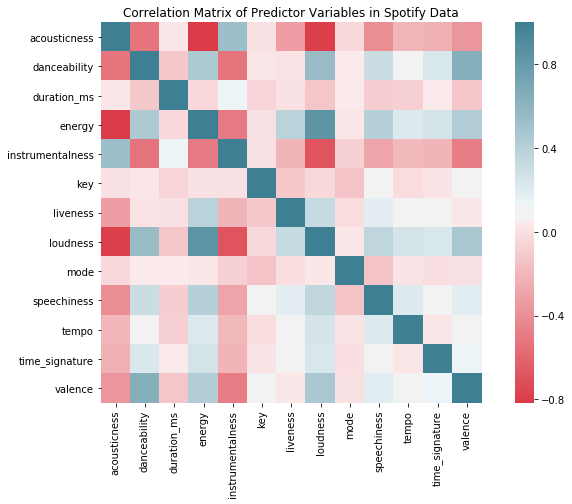

In [45]:
corr = X_test.corr('spearman')
figure(figsize=(12,7))
sns.heatmap(corr, cmap=sns.diverging_palette(10,220,as_cmap=True), square=True)
plt.title("Correlation Matrix of Predictor Variables in Spotify Data")

### KNN Analysis

In [46]:
#Fitting a grid of data with neighbors 1,3,5 to TRAINING set
sub_grid = KNNgrid(X_train, X_train, y_train, y_train,numneigh=7, scaled=1)

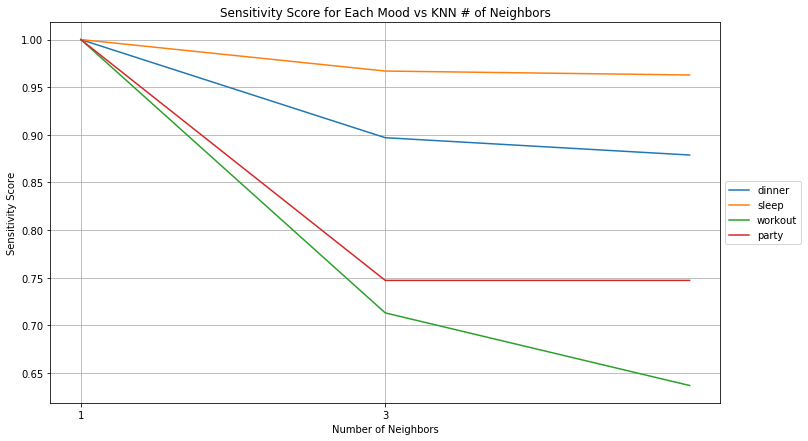

In [47]:
plotNeighbors(sub_grid,metric='Sensitivity', maxtick=5)

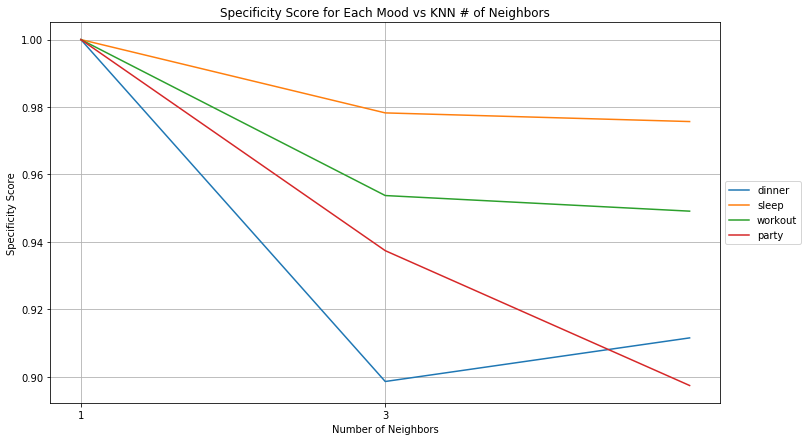

In [48]:
plotNeighbors(sub_grid,metric='Specificity', maxtick=5)

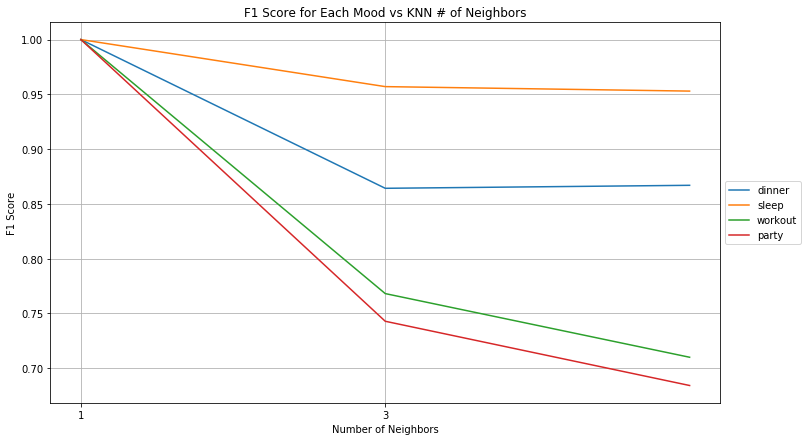

In [49]:
plotNeighbors(sub_grid, metric="F1", maxtick=5)

In [50]:
#performance metrics for neighbors at 1, 3, 5 on TRAINING data
sub_grid

Sensitivity Specificity        F1  Accuracy
1 dinner            1           1         1         1
  sleep             1           1         1         1
  workout           1           1         1         1
  party             1           1         1         1
3 dinner      0.89697    0.898625  0.864234  0.898026
  sleep      0.966942    0.978261  0.957055     0.975
  workout    0.713004    0.953757  0.768116  0.895082
  party      0.747126    0.937415  0.742857   0.90099
5 dinner     0.878788    0.911552  0.866966  0.899321
  sleep       0.96281    0.975694  0.952965  0.971883
  workout    0.636771    0.949128      0.71  0.872667
  party      0.747126    0.897436  0.684211  0.868852

In [51]:
#confusion matrix output for neighbors at 1,3,5 on TRAINING DATA
sub_grid = KNNgrid(X_train, X_train, y_train, y_train,numneigh=7, scaled=1, output='cm')
sub_grid

dinner_pred  sleep_pred  workout_pred  party_pred
1 dinner_true           330           0             0           0
  sleep_true              0         242             0           0
  workout_true            0           0           223           0
  party_true              0           0             0         174
3 dinner_true           296          13            11          10
  sleep_true              8         234             0           0
  workout_true           28           0           159          36
  party_true             23           0            21         130
5 dinner_true           290          14            12          14
  sleep_true              8         233             0           1
  workout_true           20           0           142          61
  party_true             21           0            23         130

In [52]:
#Fitting a grid of data with neighbors 1,3,5 to TESTING set
sub_grid = KNNgrid(X_train, X_test, y_train, y_test,numneigh=7, scaled=1)

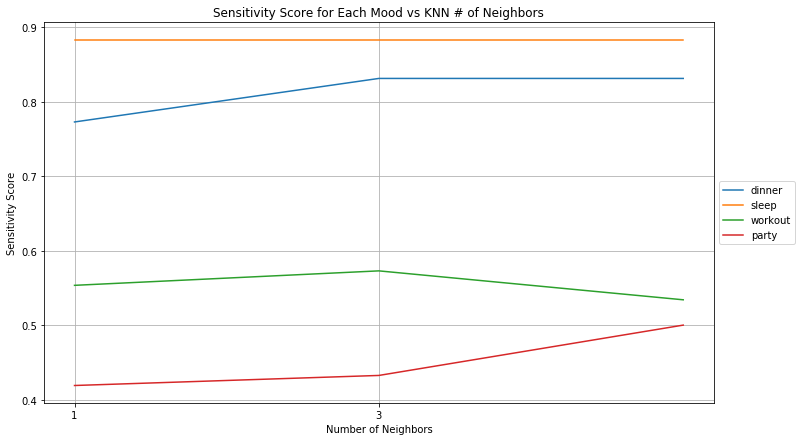

In [53]:
plotNeighbors(sub_grid,metric='Sensitivity', maxtick=5)

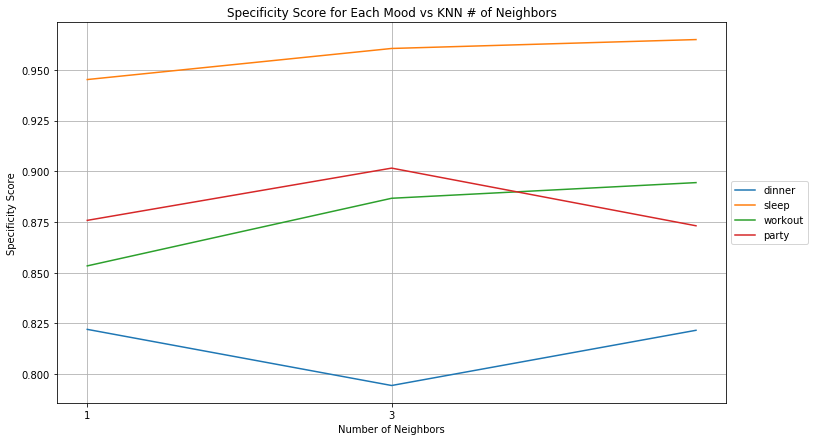

In [54]:
plotNeighbors(sub_grid,metric='Specificity', maxtick=5)

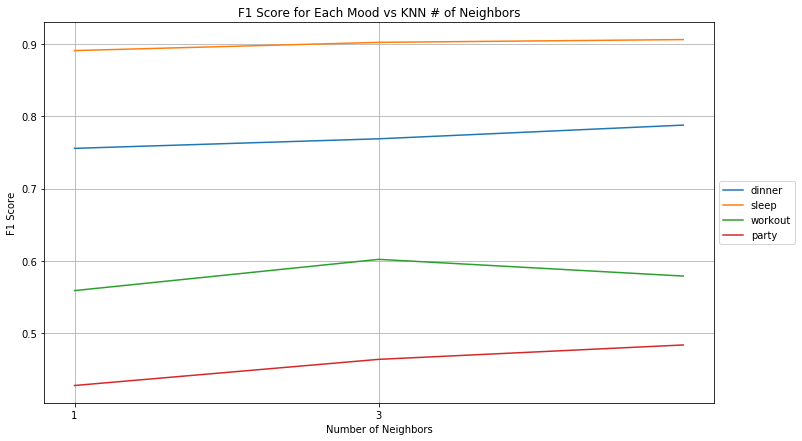

In [55]:
plotNeighbors(sub_grid, metric="F1", maxtick=5)

In [56]:
#performance metrics for neighbors at 1, 3, 5
sub_grid

Sensitivity Specificity        F1  Accuracy
1 dinner     0.772727    0.822034  0.755556  0.802564
  sleep      0.883333    0.945205  0.890756  0.923304
  workout    0.553398    0.853333  0.558824  0.776675
  party      0.418919    0.875776  0.427586  0.790404
3 dinner     0.831169    0.794355  0.768769  0.808458
  sleep      0.883333    0.960526  0.902128  0.933908
  workout    0.572816    0.886667  0.602041  0.806452
  party      0.432432    0.901538  0.463768  0.814536
5 dinner     0.831169    0.821577  0.787692  0.825316
  sleep      0.883333    0.964912  0.905983  0.936782
  workout    0.533981    0.894389  0.578947  0.802956
  party           0.5    0.873112   0.48366  0.804938

In [57]:
#confusion matrix output for neighbors at 1,3,5
sub_grid = KNNgrid(X_train, X_test, y_train, y_test,numneigh=7, scaled=1, output='cm')
sub_grid

dinner_pred  sleep_pred  workout_pred  party_pred
1 dinner_true           119          12            12          11
  sleep_true             10         106             3           1
  workout_true           18           0            57          28
  party_true             14           0            29          31
3 dinner_true           128           9             8           9
  sleep_true             13         106             0           1
  workout_true           22           0            59          22
  party_true             16           0            26          32
5 dinner_true           128           8             8          10
  sleep_true             12         106             0           2
  workout_true           18           0            55          30
  party_true             13           0            24          37

###  Most important variables

##### Testing the most important features from KNN based on cross-validated average predictive ability for single features

In [58]:
from sklearn.model_selection import cross_val_score

In [59]:
mypipeline = Pipeline([
    ('myscaler', StandardScaler()),
    ('masteralg', KNeighborsClassifier(n_neighbors=15))
])

In [60]:
for i in range(len(X_train.columns)):
    Xtmp = np.array([X_train.iloc[:,i]]).reshape(-1,1)
    scores = cross_val_score(mypipeline, Xtmp, y_train) 
    print('%s\t\t%g' %(X_train.columns[i], scores.mean()))

acousticness		0.589306
danceability		0.452038
duration_ms		0.356039
energy		0.595533
instrumentalness		0.534489
key		0.301388
liveness		0.352912
loudness		0.6285
mode		0.329185
speechiness		0.411739
tempo		0.414921


C:\Users\Charlie\Anaconda2\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


time_signature		0.344579
valence		0.448926


In [61]:
print X_train.columns[7], X_train.columns[0], X_train.columns[3]

loudness acousticness energy


Text(0,0.5,u'acousticness')

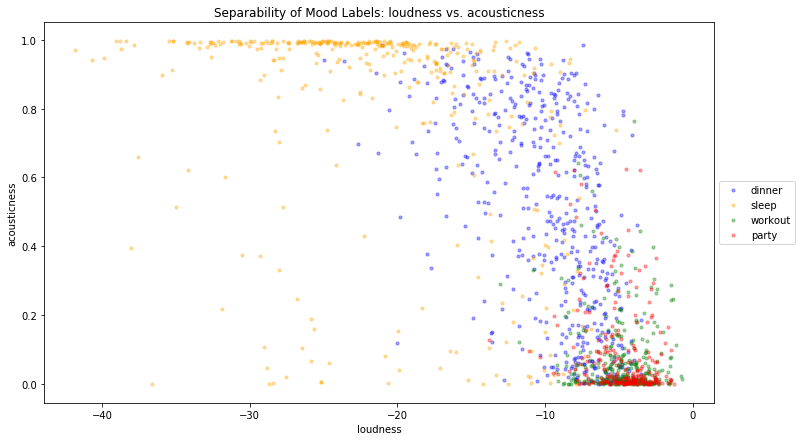

In [62]:
#plotting a combination of highly important features
x1_rand, x2_rand = 'loudness', 'acousticness'

#setting up different points to plot for each class
mood1 = df2.loc[df2['mood(s)']=='dinner']
mood2 = df2.loc[df2['mood(s)']=='sleep']
mood3 = df2.loc[df2['mood(s)']=='workout']
mood4 = df2.loc[df2['mood(s)']=='party']

groups = (mood1, mood2, mood3, mood4)
labels = ['dinner', 'sleep', 'workout', 'party']
colors = ['blue', 'orange', 'green', 'red']

figure(figsize=(12,7))
for g, l, c in zip(groups, labels, colors):
    plt.scatter(g[x1_rand], g[x2_rand], c=c, alpha=0.35, label=l, s=10)
    
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.title("Separability of Mood Labels: " + x1_rand + " vs. " + x2_rand)
plt.xlabel(x1_rand)
plt.ylabel(x2_rand)